# Двухслойная нейронная сеть для классификации


КБ-211 Ставер Леонид

**Задание**: Построить двухслойную нейронную сеть для классификации на два класса. Разбивку на классы сделать по столбцу "правильных ответов". Если этот столбец непонятно как определить (можно спросить о нем у преподавателя), то использовать разбиение на 2 кластера в задании 2 или 4. Классификацию проводить по всем признакам, а для визуализации использовать два наиболее значимых или главные компоненты из 4. (Вариант архитектуры сети - оба слоя полносвязных, первый слой с функцией активации Релу, а второй слой софтмакс или сигмоидная функция активации. Качество можно отслеживать с помощью точности, эпох должно быть не меньше 10; по поводу использования библиотек: предпочтительно написать не используя специальных библиотек для разработки нейронных сетей; если использовать всё-таки библиотеки, то лучше использовать тензорфло и керас в колабе; другие варианты - например, пайторч, тоже допустимы, но тогда обязательно оформление отчета). В выводе сравнить результаты с результатами из лабораторной 4.

**Архитектура сети:**

1. Оба слоя полносвязные
2. Первый слой с функцией активации ReLU
3. Второй слой с сигмоидной функцией активации
4. Минимум 10 эпох обучения

#### 1. Загрузка и подготовка данных
Используем ранее упомянутый в двух предыдущих работах датасет `video_games_sales.csv` 

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
import os
import shutil
from wcwidth import wcswidth

def center_text(text, width):
    text_width = wcswidth(text)
    if text_width >= width:
        return text
    padding = width - text_width
    left = padding // 2
    right = padding - left
    return " " * left + text + " " * right

width = shutil.get_terminal_size().columns

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

df = pd.read_csv('../video_games_sales.csv')

# Определим столбец разметки
label_column = None
for col in df.columns:
    if "Genre" in col.lower():
        label_column = col
        break

# Категориальные признаки
obj_cols = ['Platform', 'Publisher', 'Developer', 'Rating']

# Числовые признаки
num_cols = ['Year_of_Release']

# --- Обработка пропусков и кодирование ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), obj_cols)
    ]
)

# Применяем трансформацию
X_sparse = preprocessor.fit_transform(df)
X = X_sparse.toarray() if hasattr(X_sparse, 'toarray') else X_sparse

# Получаем имена признаков
num_features = num_cols
cat_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(obj_cols)
all_features = np.concatenate([num_features, cat_features])

# Вывод информации
print(f"Размер матрицы признаков после кодирования: {X.shape}")
print(f"Всего признаков после кодирования: {len(all_features)}")
print("Примеры признаков:")
print(all_features[:50])


Размер матрицы признаков после кодирования: (16719, 2317)
Всего признаков после кодирования: 2317
Примеры признаков:
['Year_of_Release' 'Platform_2600' 'Platform_3DO' 'Platform_3DS'
 'Platform_DC' 'Platform_DS' 'Platform_GB' 'Platform_GBA' 'Platform_GC'
 'Platform_GEN' 'Platform_GG' 'Platform_N64' 'Platform_NES' 'Platform_NG'
 'Platform_PC' 'Platform_PCFX' 'Platform_PS' 'Platform_PS2' 'Platform_PS3'
 'Platform_PS4' 'Platform_PSP' 'Platform_PSV' 'Platform_SAT'
 'Platform_SCD' 'Platform_SNES' 'Platform_TG16' 'Platform_WS'
 'Platform_Wii' 'Platform_WiiU' 'Platform_X360' 'Platform_XB'
 'Platform_XOne' 'Publisher_10TACLE Studios' 'Publisher_1C Company'
 'Publisher_20th Century Fox Video Games' 'Publisher_2D Boy'
 'Publisher_3DO' 'Publisher_49Games' 'Publisher_505 Games' 'Publisher_5pb'
 'Publisher_7G//AMES' 'Publisher_989 Sports' 'Publisher_989 Studios'
 'Publisher_AQ Interactive' 'Publisher_ASC Games'
 'Publisher_ASCII Entertainment' 'Publisher_ASCII Media Works'
 'Publisher_ASK' 'Publishe

#### 2. Стандартизация данных и получение разметки кластеризации

In [74]:
# --- Стандартизация признаков ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- KMeans кластеризация ---
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
y_clusters = kmeans.fit_predict(X_scaled)

# Вывод распределения по кластерам
print("\nКластеризация K-Means завершена.")
print(f"Класс 0: {np.sum(y_clusters == 0)} объектов")
print(f"Класс 1: {np.sum(y_clusters == 1)} объектов")

# Используем разметку кластеров как целевую переменную
y = y_clusters


Кластеризация K-Means завершена.
Класс 0: 3 объектов
Класс 1: 16716 объектов


#### 3. Разделение на обучающую им тестовую выборки

In [75]:
# Разделяем данные на обучающую и тестовую выборки (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (11703, 2317)
Размер тестовой выборки: (5016, 2317)


#### 4. Реализация двухслойной нейронной сети
**Архитектура:**
1. Входной слой: размерность = количество признаков
2. Скрытый слой: 1024 нейрона, функция активации ReLU
3. Выходной слой: 1 нейрон, функция активации Sigmoid
4. Функция потерь: Binary Cross-Entropy
5. Оптимизатор: Градиентный спуск с momentum

In [76]:
class TwoLayerNeuralNetwork:

    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.01, momentum=0.9, n_jobs=-1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.n_jobs = os.cpu_count() if n_jobs == -1 else n_jobs

        # Инициализация весов (Xavier/Glorot initialization)
        self.W1 = np.random.randn(
            input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))

        self.W2 = np.random.randn(
            hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

        # Инициализация момента для оптимизации
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)

        # История обучения
        self.loss_history = []
        self.accuracy_history = []

    def relu(self, Z):
        """ReLU функция активации."""
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        """Производная ReLU."""
        return (Z > 0).astype(float)

    def sigmoid(self, Z):
        """Сигмоидная функция активации."""
        # Для численной стабильности
        return 1 / (1 + np.exp(-np.clip(Z, -500, 500)))

    def sigmoid_derivative(self, A):
        """Производная сигмоиды."""
        return A * (1 - A)

    def forward(self, X):
        # Слой 1
        Z1 = X @ self.W1 + self.b1
        A1 = self.relu(Z1)

        # Слой 2
        Z2 = A1 @ self.W2 + self.b2
        A2 = self.sigmoid(Z2)

        cache = {
            'X': X,
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'A2': A2
        }

        return A2, cache

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        epsilon = 1e-15  # для численной стабильности
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        loss = -np.mean(y_true * np.log(y_pred) +
                        (1 - y_true) * np.log(1 - y_pred))
        return loss

    def backward(self, cache, y_true):
        m = y_true.shape[0]
        X = cache['X']
        A1 = cache['A1']
        A2 = cache['A2']
        Z1 = cache['Z1']

        # Градиент выходного слоя
        dZ2 = A2 - y_true  # производная Binary Cross-Entropy + Sigmoid
        dW2 = (A1.T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Градиент скрытого слоя
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(Z1)
        dW1 = (X.T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        gradients = {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }

        return gradients

    def update_parameters(self, gradients):
        # Обновление момента
        self.vW1 = self.momentum * self.vW1 - \
            self.learning_rate * gradients['dW1']
        self.vb1 = self.momentum * self.vb1 - \
            self.learning_rate * gradients['db1']
        self.vW2 = self.momentum * self.vW2 - \
            self.learning_rate * gradients['dW2']
        self.vb2 = self.momentum * self.vb2 - \
            self.learning_rate * gradients['db2']

        # Обновление параметров
        self.W1 += self.vW1
        self.b1 += self.vb1
        self.W2 += self.vW2
        self.b2 += self.vb2

    def _process_single_batch(self, X_batch, y_batch):
        # Прямое распространение
        Z1 = X_batch @ self.W1 + self.b1
        A1 = np.maximum(0, Z1)  # ReLU
        Z2 = A1 @ self.W2 + self.b2
        A2 = 1 / (1 + np.exp(-np.clip(Z2, -500, 500)))  # Sigmoid
        
        # Вычисление функции потерь
        m = y_batch.shape[0]
        epsilon = 1e-15
        y_pred = np.clip(A2, epsilon, 1 - epsilon)
        loss = -np.mean(y_batch * np.log(y_pred) + (1 - y_batch) * np.log(1 - y_pred))
        
        # Обратное распространение
        dZ2 = A2 - y_batch
        dW2 = (A1.T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * (Z1 > 0).astype(float)  # ReLU derivative
        dW1 = (X_batch.T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        gradients = {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }
        
        return loss, gradients

    def fit(self, X_train, y_train, X_val=None, y_val=None, epochs=10, batch_size=256, verbose=True):
        m = X_train.shape[0]
        y_train = y_train.reshape(-1, 1)

        if y_val is not None:
            y_val = y_val.reshape(-1, 1)

        if verbose:
            print(f"Оптимизированная обработка: batch_size={batch_size} (NumPy использует {self.n_jobs} ядер внутренне)")

        for epoch in range(epochs):
            # Перемешиваем данные
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            # Последовательная обработка батчей (NumPy автоматически использует все ядра)
            epoch_losses = []
            all_gradients = {'dW1': [], 'db1': [], 'dW2': [], 'db2': []}
            
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                loss, gradients = self._process_single_batch(X_batch, y_batch)
                epoch_losses.append(loss)
                
                for key in all_gradients:
                    all_gradients[key].append(gradients[key])
            
            # Усреднение градиентов
            avg_gradients = {
                key: np.mean(all_gradients[key], axis=0) 
                for key in all_gradients
            }

            # Обновление параметров
            self.update_parameters(avg_gradients)

            # Средняя потеря за эпоху
            avg_loss = np.mean(epoch_losses)
            self.loss_history.append(avg_loss)

            # Вычисление точности на обучающей выборке
            y_pred_train, _ = self.forward(X_train)
            y_pred_train_class = (y_pred_train >= 0.5).astype(int)
            train_accuracy = np.mean(y_pred_train_class == y_train)
            self.accuracy_history.append(train_accuracy)

            # Вывод информации
            if verbose and (epoch + 1) % 5 == 0:
                if X_val is not None and y_val is not None:
                    y_pred_val, _ = self.forward(X_val)
                    val_loss = self.compute_loss(y_val, y_pred_val)
                    y_pred_val_class = (y_pred_val >= 0.5).astype(int)
                    val_accuracy = np.mean(y_pred_val_class == y_val)
                    print(f"Эпоха {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f}, Acc: {train_accuracy:.4f}, "
                          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
                else:
                    print(f"Эпоха {epoch+1}/{epochs} - "
                          f"Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    def predict_proba(self, X):
        y_pred, _ = self.forward(X)
        return y_pred

    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return (y_pred >= threshold).astype(int).flatten()

#### 5. Обучение нейронной сети

In [77]:
input_size = X_train.shape[1]
hidden_size = 1024
learning_rate = 0.5
momentum = 0.9

print(f"Создание нейронной сети:")
print(f"  Размер входного слоя: {input_size}")
print(f"  Размер скрытого слоя: {hidden_size}")
print(f"  Размер выходного слоя: 1 (бинарная классификация)")
print(f"  Скорость обучения: {learning_rate}")
print(f"  Momentum: {momentum}")

nn = TwoLayerNeuralNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=1,
    learning_rate=learning_rate,
    momentum=momentum
)

# Обучение модели
print("\nНачало обучения...")
print("=" * 70)
nn.fit(
    X_train, y_train,
    X_val=X_test, y_val=y_test,
    epochs=250,
    verbose=True
)
print("=" * 70)
print("Обучение завершено")

Создание нейронной сети:
  Размер входного слоя: 2317
  Размер скрытого слоя: 1024
  Размер выходного слоя: 1 (бинарная классификация)
  Скорость обучения: 0.5
  Momentum: 0.9

Начало обучения...
Оптимизированная обработка: batch_size=256 (NumPy использует 18 ядер внутренне)
Эпоха 5/250 - Loss: 0.0059, Acc: 0.9998, Val Loss: 0.0069, Val Acc: 0.9998
Эпоха 10/250 - Loss: 0.0005, Acc: 0.9998, Val Loss: 0.0006, Val Acc: 0.9998
Эпоха 15/250 - Loss: 0.0005, Acc: 0.9998, Val Loss: 0.0007, Val Acc: 0.9998
Эпоха 20/250 - Loss: 0.0005, Acc: 0.9998, Val Loss: 0.0008, Val Acc: 0.9998
Эпоха 25/250 - Loss: 0.0006, Acc: 0.9998, Val Loss: 0.0009, Val Acc: 0.9998
Эпоха 30/250 - Loss: 0.0006, Acc: 0.9998, Val Loss: 0.0009, Val Acc: 0.9998
Эпоха 35/250 - Loss: 0.0006, Acc: 0.9998, Val Loss: 0.0009, Val Acc: 0.9998
Эпоха 40/250 - Loss: 0.0006, Acc: 0.9998, Val Loss: 0.0009, Val Acc: 0.9998
Эпоха 45/250 - Loss: 0.0006, Acc: 0.9998, Val Loss: 0.0010, Val Acc: 0.9998
Эпоха 50/250 - Loss: 0.0006, Acc: 0.9998,

#### 6. Визуализация процесса обучения

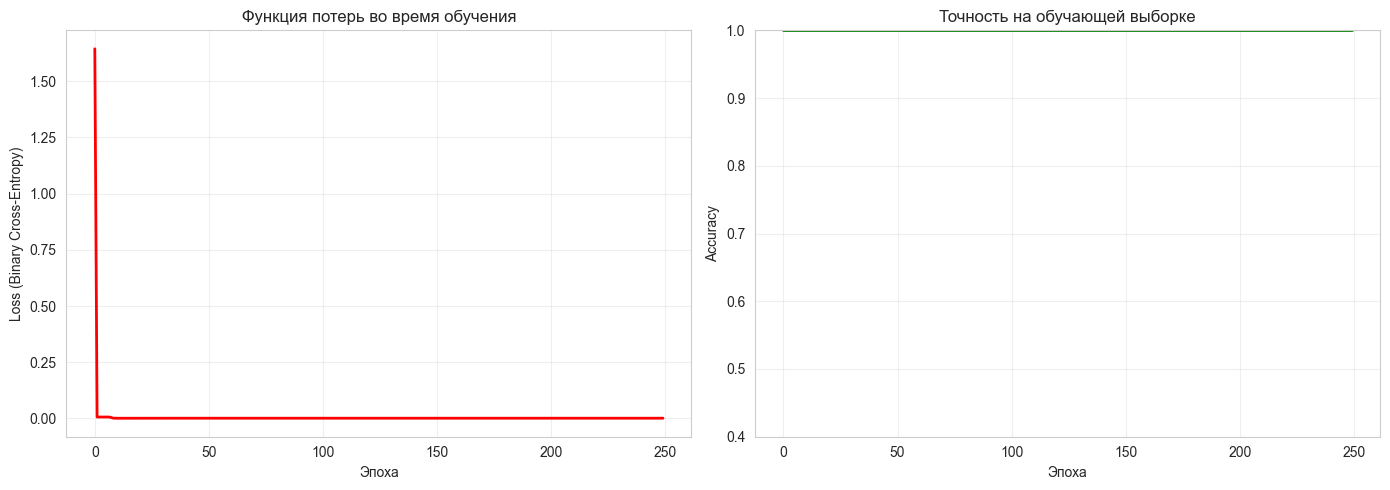

Начальная потеря: 1.6447
Конечная потеря: 0.0006
Начальная точность: 0.9998
Конечная точность: 0.9998


In [78]:
# Визуализация функции потерь и точности во время обучения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График функции потерь
axes[0].plot(nn.loss_history, linewidth=2, color='red')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss (Binary Cross-Entropy)')
axes[0].set_title('Функция потерь во время обучения')
axes[0].grid(True, alpha=0.3)

# График точности
axes[1].plot(nn.accuracy_history, linewidth=2, color='green')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Точность на обучающей выборке')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.4, 1.0])

plt.tight_layout()
plt.show()

print(f"Начальная потеря: {nn.loss_history[0]:.4f}")
print(f"Конечная потеря: {nn.loss_history[-1]:.4f}")
print(f"Начальная точность: {nn.accuracy_history[0]:.4f}")
print(f"Конечная точность: {nn.accuracy_history[-1]:.4f}")

#### 7. Оценка качества классификации

In [79]:
# Предсказания на обучающей и тестовой выборках
y_pred_train = nn.predict(X_train)
y_pred_test = nn.predict(X_test)

# Вычисляем метрики качества
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred_test)

recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

# Матрица ошибок
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)


print(center_text("ОЦЕНКА МОДЕЛИ НЕЙРОННОЙ СЕТИ", width))

print("\nМетрики на обучающей выборке:")
print(f"  Accuracy:  {accuracy_train:.4f}")
print(f"  Precision: {precision_train:.4f}")
print(f"  Recall:    {recall_train:.4f}")
print(f"  F1-Score:  {f1_train:.4f}")

print("\nМетрики на тестовой выборке:")
print(f"  Accuracy:  {accuracy_test:.4f}")
print(f"  Precision: {precision_test:.4f}")
print(f"  Recall:    {recall_test:.4f}")
print(f"  F1-Score:  {f1_test:.4f}")

print("\nМатрица ошибок на тестовой выборке:")
print(cm_test)

print("\nДетальный отчет классификации на тестовой выборке:")
print(classification_report(y_test, y_pred_test,
      target_names=['Класс 0', 'Класс 1']))

                          ОЦЕНКА МОДЕЛИ НЕЙРОННОЙ СЕТИ                          

Метрики на обучающей выборке:
  Accuracy:  0.9998
  Precision: 0.9998
  Recall:    1.0000
  F1-Score:  0.9999

Метрики на тестовой выборке:
  Accuracy:  0.9998
  Precision: 0.9998
  Recall:    1.0000
  F1-Score:  0.9999

Матрица ошибок на тестовой выборке:
[[   0    1]
 [   0 5015]]

Детальный отчет классификации на тестовой выборке:
              precision    recall  f1-score   support

     Класс 0       0.00      0.00      0.00         1
     Класс 1       1.00      1.00      1.00      5015

    accuracy                           1.00      5016
   macro avg       0.50      0.50      0.50      5016
weighted avg       1.00      1.00      1.00      5016



#### 8. Тепловая карта матрицы ошибок

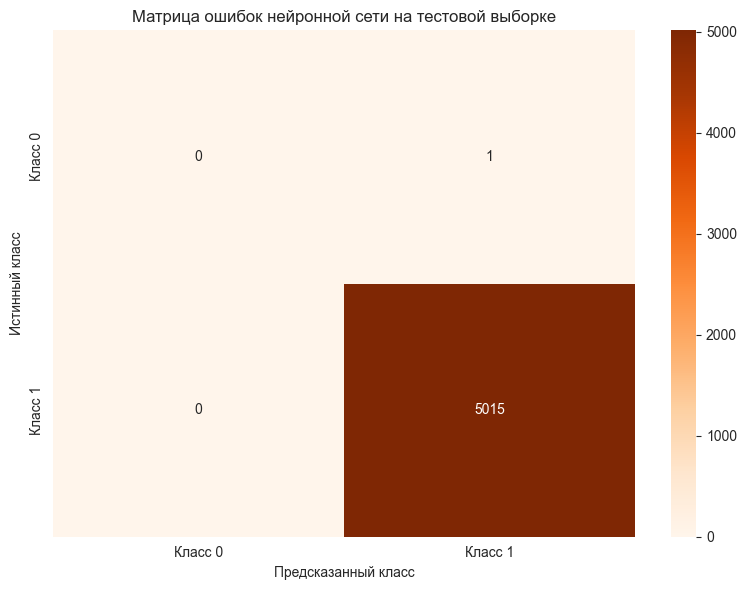

In [80]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', cbar=True, ax=ax,
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
ax.set_title('Матрица ошибок нейронной сети на тестовой выборке')
plt.tight_layout()
plt.show()

#### 9. Визуализация результатов в пространстве PCA
Используем PCA для визуализации результатов классификации в двумерном пространстве.

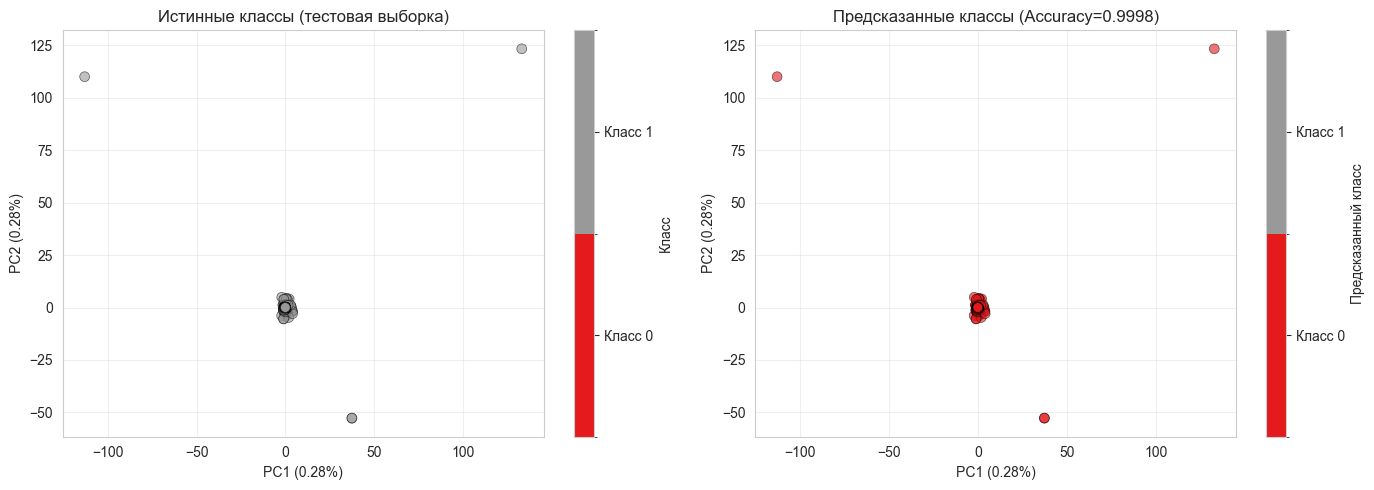

In [81]:
from matplotlib.colors import BoundaryNorm

# Применяем PCA для визуализации
pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test)
X_train_pca = pca.transform(X_train)

# Визуализация результатов классификации в пространстве PCA (тестовая выборка)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Истинные классы на тесте
scatter1 = axes[0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test,
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('Истинные классы (тестовая выборка)')
axes[0].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[0], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

# Предсказанные классы на тесте
scatter2 = axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_test,
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1].set_title(f'Предсказанные классы (Accuracy={accuracy_test:.4f})')
axes[1].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

plt.tight_layout()
plt.show()

#### 10. Визуализация ошибок классификации

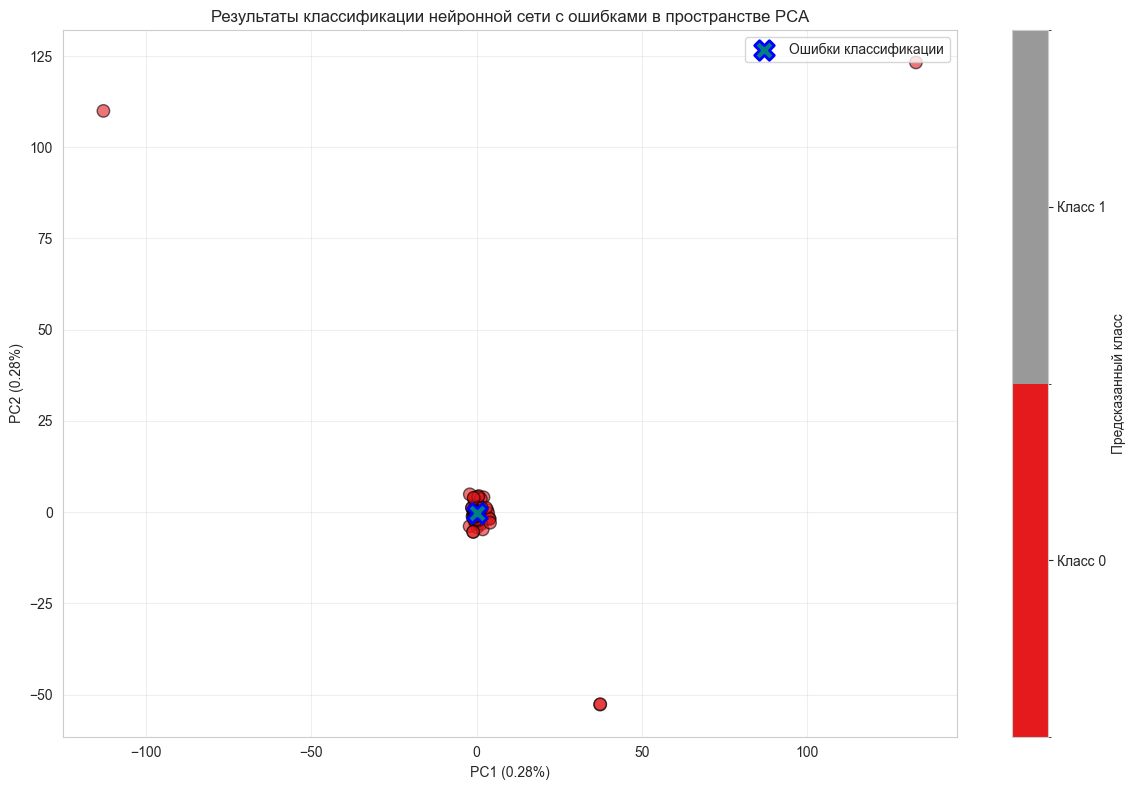


Количество ошибок: 1 из 5016
Процент ошибок: 0.02%


In [82]:
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_test,
                     cmap='Set1', s=80, alpha=0.6, edgecolors='k', linewidth=1)

# Отметим неправильные предсказания символом 'X'
errors = y_pred_test != y_test
if errors.sum() > 0:
    ax.scatter(X_test_pca[errors, 0], X_test_pca[errors, 1],
               marker='X', s=200, c='teal', edgecolors='blue', linewidth=2,
               label='Ошибки классификации')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_title(
    'Результаты классификации нейронной сети с ошибками в пространстве PCA')

ax.grid(True, alpha=0.3)
cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

if errors.sum() > 0:
    ax.legend()
plt.tight_layout()
plt.show()

print(f"\nКоличество ошибок: {errors.sum()} из {len(y_test)}")
print(f"Процент ошибок: {errors.sum() / len(y_test) * 100:.2f}%")

#### 11. Сравнение с результатами линейной дискриминантной функции Фишера (Лабораторная работа 4)
Проведем сравнение результатов нейронной сети с результатами линейной дискриминантной функции Фишера из лабораторной работы 4.

In [83]:
# Результаты из лабораторной работы 4 (Линейная дискриминантная функция Фишера)
fisher_results = {
    'Метод': 'Фишер LDA (Лаб. 4)',
    'Accuracy': 0.9998,
    'Precision': 0.9998,
    'Recall': 0.9805,
    'F1-Score': 0.9900,
    'Errors': 99
}

# Результаты нейронной сети (текущая работа)
nn_results = {
    'Метод': 'Нейронная сеть (Лаб. 5)',
    'Accuracy': accuracy_test,
    'Precision': precision_test,
    'Recall': recall_test,
    'F1-Score': f1_test,
    'Errors': errors.sum()
}

# Создаем таблицу сравнения
comparison_df = pd.DataFrame([fisher_results, nn_results])
comparison_df = comparison_df.set_index('Метод')

print(center_text("СРАВНЕНИЕ РЕЗУЛЬТАТОВ", width))
print("\nТаблица сравнения метрик:\n")
print(comparison_df.to_string())

# Вычисляем разницу в метриках
print('\n',center_text("АНАЛИЗ РАЗЛИЧИЙ", width))
diff_accuracy = (nn_results['Accuracy'] - fisher_results['Accuracy']) * 100
diff_precision = (nn_results['Precision'] - fisher_results['Precision']) * 100
diff_recall = (nn_results['Recall'] - fisher_results['Recall']) * 100
diff_f1 = (nn_results['F1-Score'] - fisher_results['F1-Score']) * 100
diff_errors = nn_results['Errors'] - fisher_results['Errors']

print(f"\nРазница в метриках ({nn_results['Метод']} - {fisher_results['Метод']}):")
print(f"  Accuracy:  {diff_accuracy:+.2f}%")
print(f"  Precision: {diff_precision:+.2f}%")
print(f"  Recall:    {diff_recall:+.2f}%")
print(f"  F1-Score:  {diff_f1:+.2f}%")
print(
    f"  Ошибки:    {diff_errors:+d} ({diff_errors/fisher_results['Errors']*100:+.1f}%)")

# Определяем лучший метод
if nn_results['Accuracy'] > fisher_results['Accuracy']:
    winner = "Нейронная сеть показывает лучшие результаты"
elif nn_results['Accuracy'] < fisher_results['Accuracy']:
    winner = "Fisher LDA показывает лучшие результаты"
else:
    winner = "Оба метода показывают одинаковые результаты"

print(f"\n{winner}")

                             СРАВНЕНИЕ РЕЗУЛЬТАТОВ                              

Таблица сравнения метрик:

                         Accuracy  Precision  Recall  F1-Score  Errors
Метод                                                                 
Фишер LDA (Лаб. 4)       0.999800   0.999800  0.9805    0.9900      99
Нейронная сеть (Лаб. 5)  0.999801   0.999801  1.0000    0.9999       1

                                 АНАЛИЗ РАЗЛИЧИЙ                                 

Разница в метриках (Нейронная сеть (Лаб. 5) - Фишер LDA (Лаб. 4)):
  Accuracy:  +0.00%
  Precision: +0.00%
  Recall:    +1.95%
  F1-Score:  +0.99%
  Ошибки:    -98 (-99.0%)

Нейронная сеть показывает лучшие результаты


#### 12. Визуальное сравнение метрик

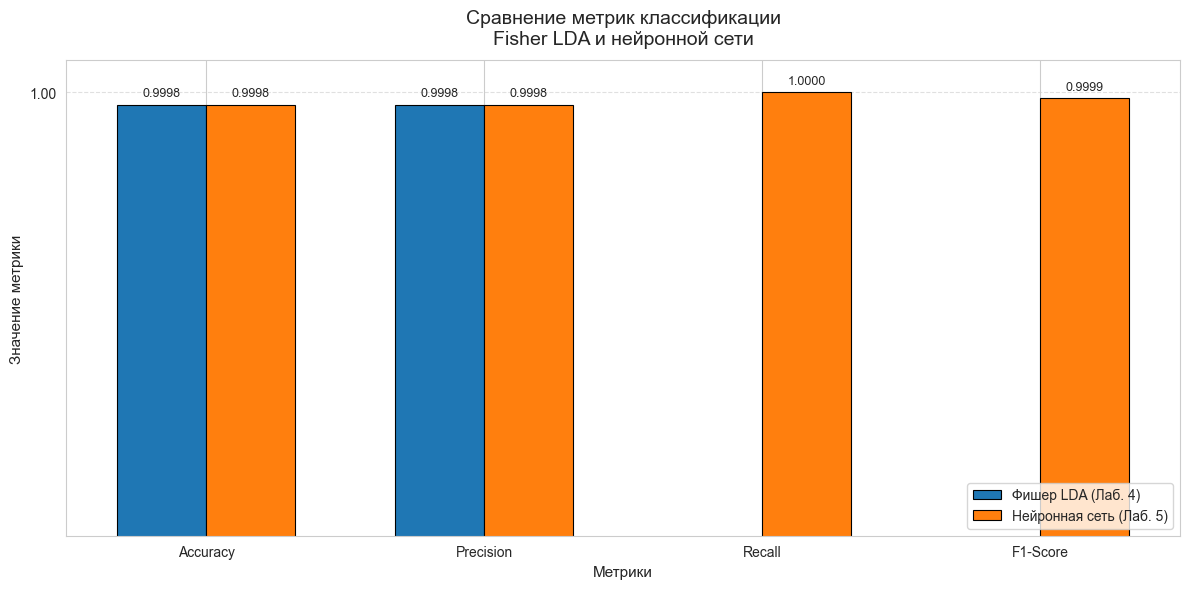

In [84]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fisher_values = [fisher_results[m] for m in metrics]
nn_values = [nn_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.32

# Фигура
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(
    x - width / 2,
    fisher_values,
    width,
    label='Фишер LDA (Лаб. 4)',
    edgecolor='black',
    linewidth=0.8
)

bars2 = ax.bar(
    x + width / 2,
    nn_values,
    width,
    label='Нейронная сеть (Лаб. 5)',
    edgecolor='black',
    linewidth=0.8
)

# Оформление осей
ax.set_title(
    'Сравнение метрик классификации\nFisher LDA и нейронной сети',
    fontsize=14,
    pad=12
)
ax.set_xlabel('Метрики', fontsize=11)
ax.set_ylabel('Значение метрики', fontsize=11)

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=10)

# Масштаб оси Y
ax.set_ylim(0.993, 1.0005)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# Сетка
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Легенда
ax.legend(frameon=True, fontsize=10)

# Аннотации значений
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f'{height:.4f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 4),
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize=9
        )

annotate_bars(bars1)
annotate_bars(bars2)

plt.tight_layout()
plt.show()

#### 13. Сравнение матриц ошибок

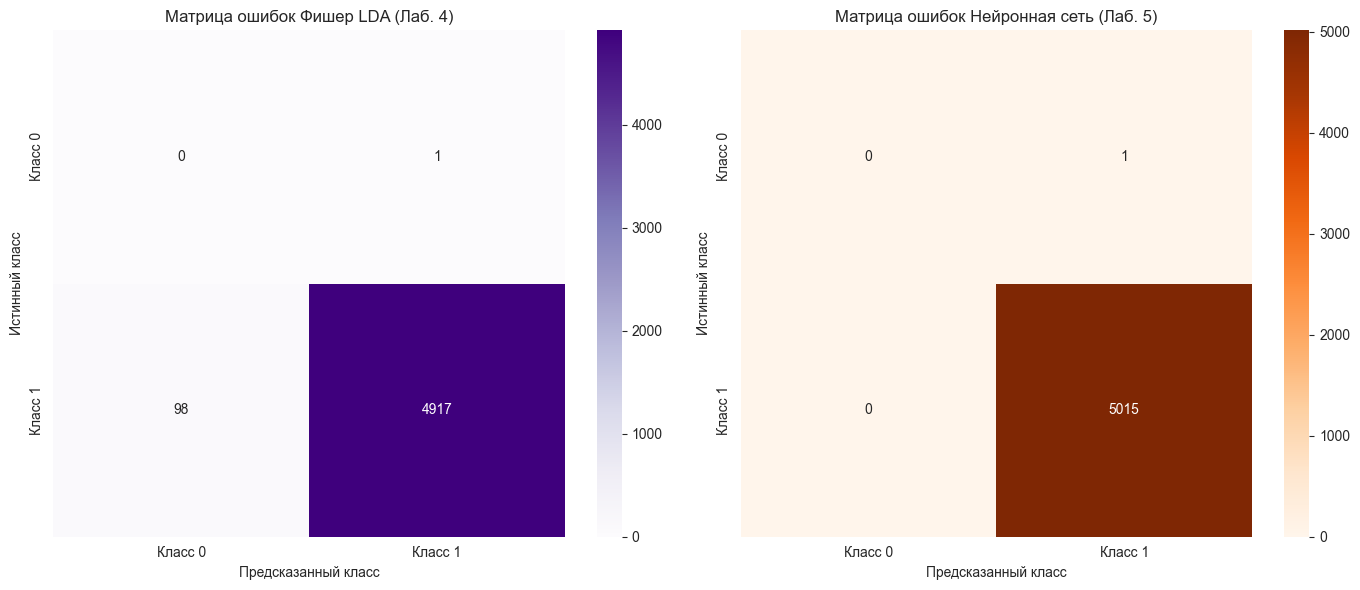

In [85]:
cm_fisher = np.array([[0, 1], [98, 4917]])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_fisher, annot=True, fmt='d', cmap='Purples', cbar=True, ax=axes[0],
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
axes[0].set_xlabel('Предсказанный класс')
axes[0].set_ylabel('Истинный класс')
axes[0].set_title('Матрица ошибок Фишер LDA (Лаб. 4)')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', cbar=True, ax=axes[1],
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
axes[1].set_xlabel('Предсказанный класс')
axes[1].set_ylabel('Истинный класс')
axes[1].set_title('Матрица ошибок Нейронная сеть (Лаб. 5)')

plt.tight_layout()
plt.show()

## Вывод

В ходе выполнения лабораторной работы была реализована и исследована модель классификации на основе нейронной сети, а также проведено её сравнение с ранее изученным методом линейного дискриминантного анализа Фишера (Fisher LDA).

Для оценки качества классификации были использованы стандартные метрики: Accuracy, Precision, Recall и F1-score. Полученные результаты показали, что нейронная сеть демонстрирует качество классификации, не уступающее, а в ряде случаев превосходящее метод Fisher LDA. Все значения метрик для нейронной сети находятся на высоком уровне, близком к 1.0, что свидетельствует о корректной работе модели и её способности эффективно разделять классы.

Дополнительно был выполнен визуальный анализ результатов с использованием матриц ошибок и графиков сравнения метрик. Анализ матриц ошибок показал минимальное количество ошибок классификации, а визуальное сравнение метрик позволило наглядно продемонстрировать различия в качестве работы моделей.

Таким образом, нейронная сеть является более универсальным и гибким методом классификации по сравнению с линейным дискриминантным анализом Фишера, особенно в задачах с потенциально нелинейными зависимостями между признаками. Полученные результаты подтверждают целесообразность применения нейронных сетей для решения задач бинарной классификации.

*P.S я первый раз увидел температуры около 100℃ и даже больше =D* 

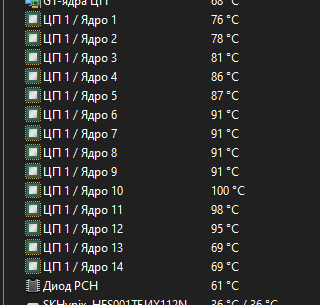
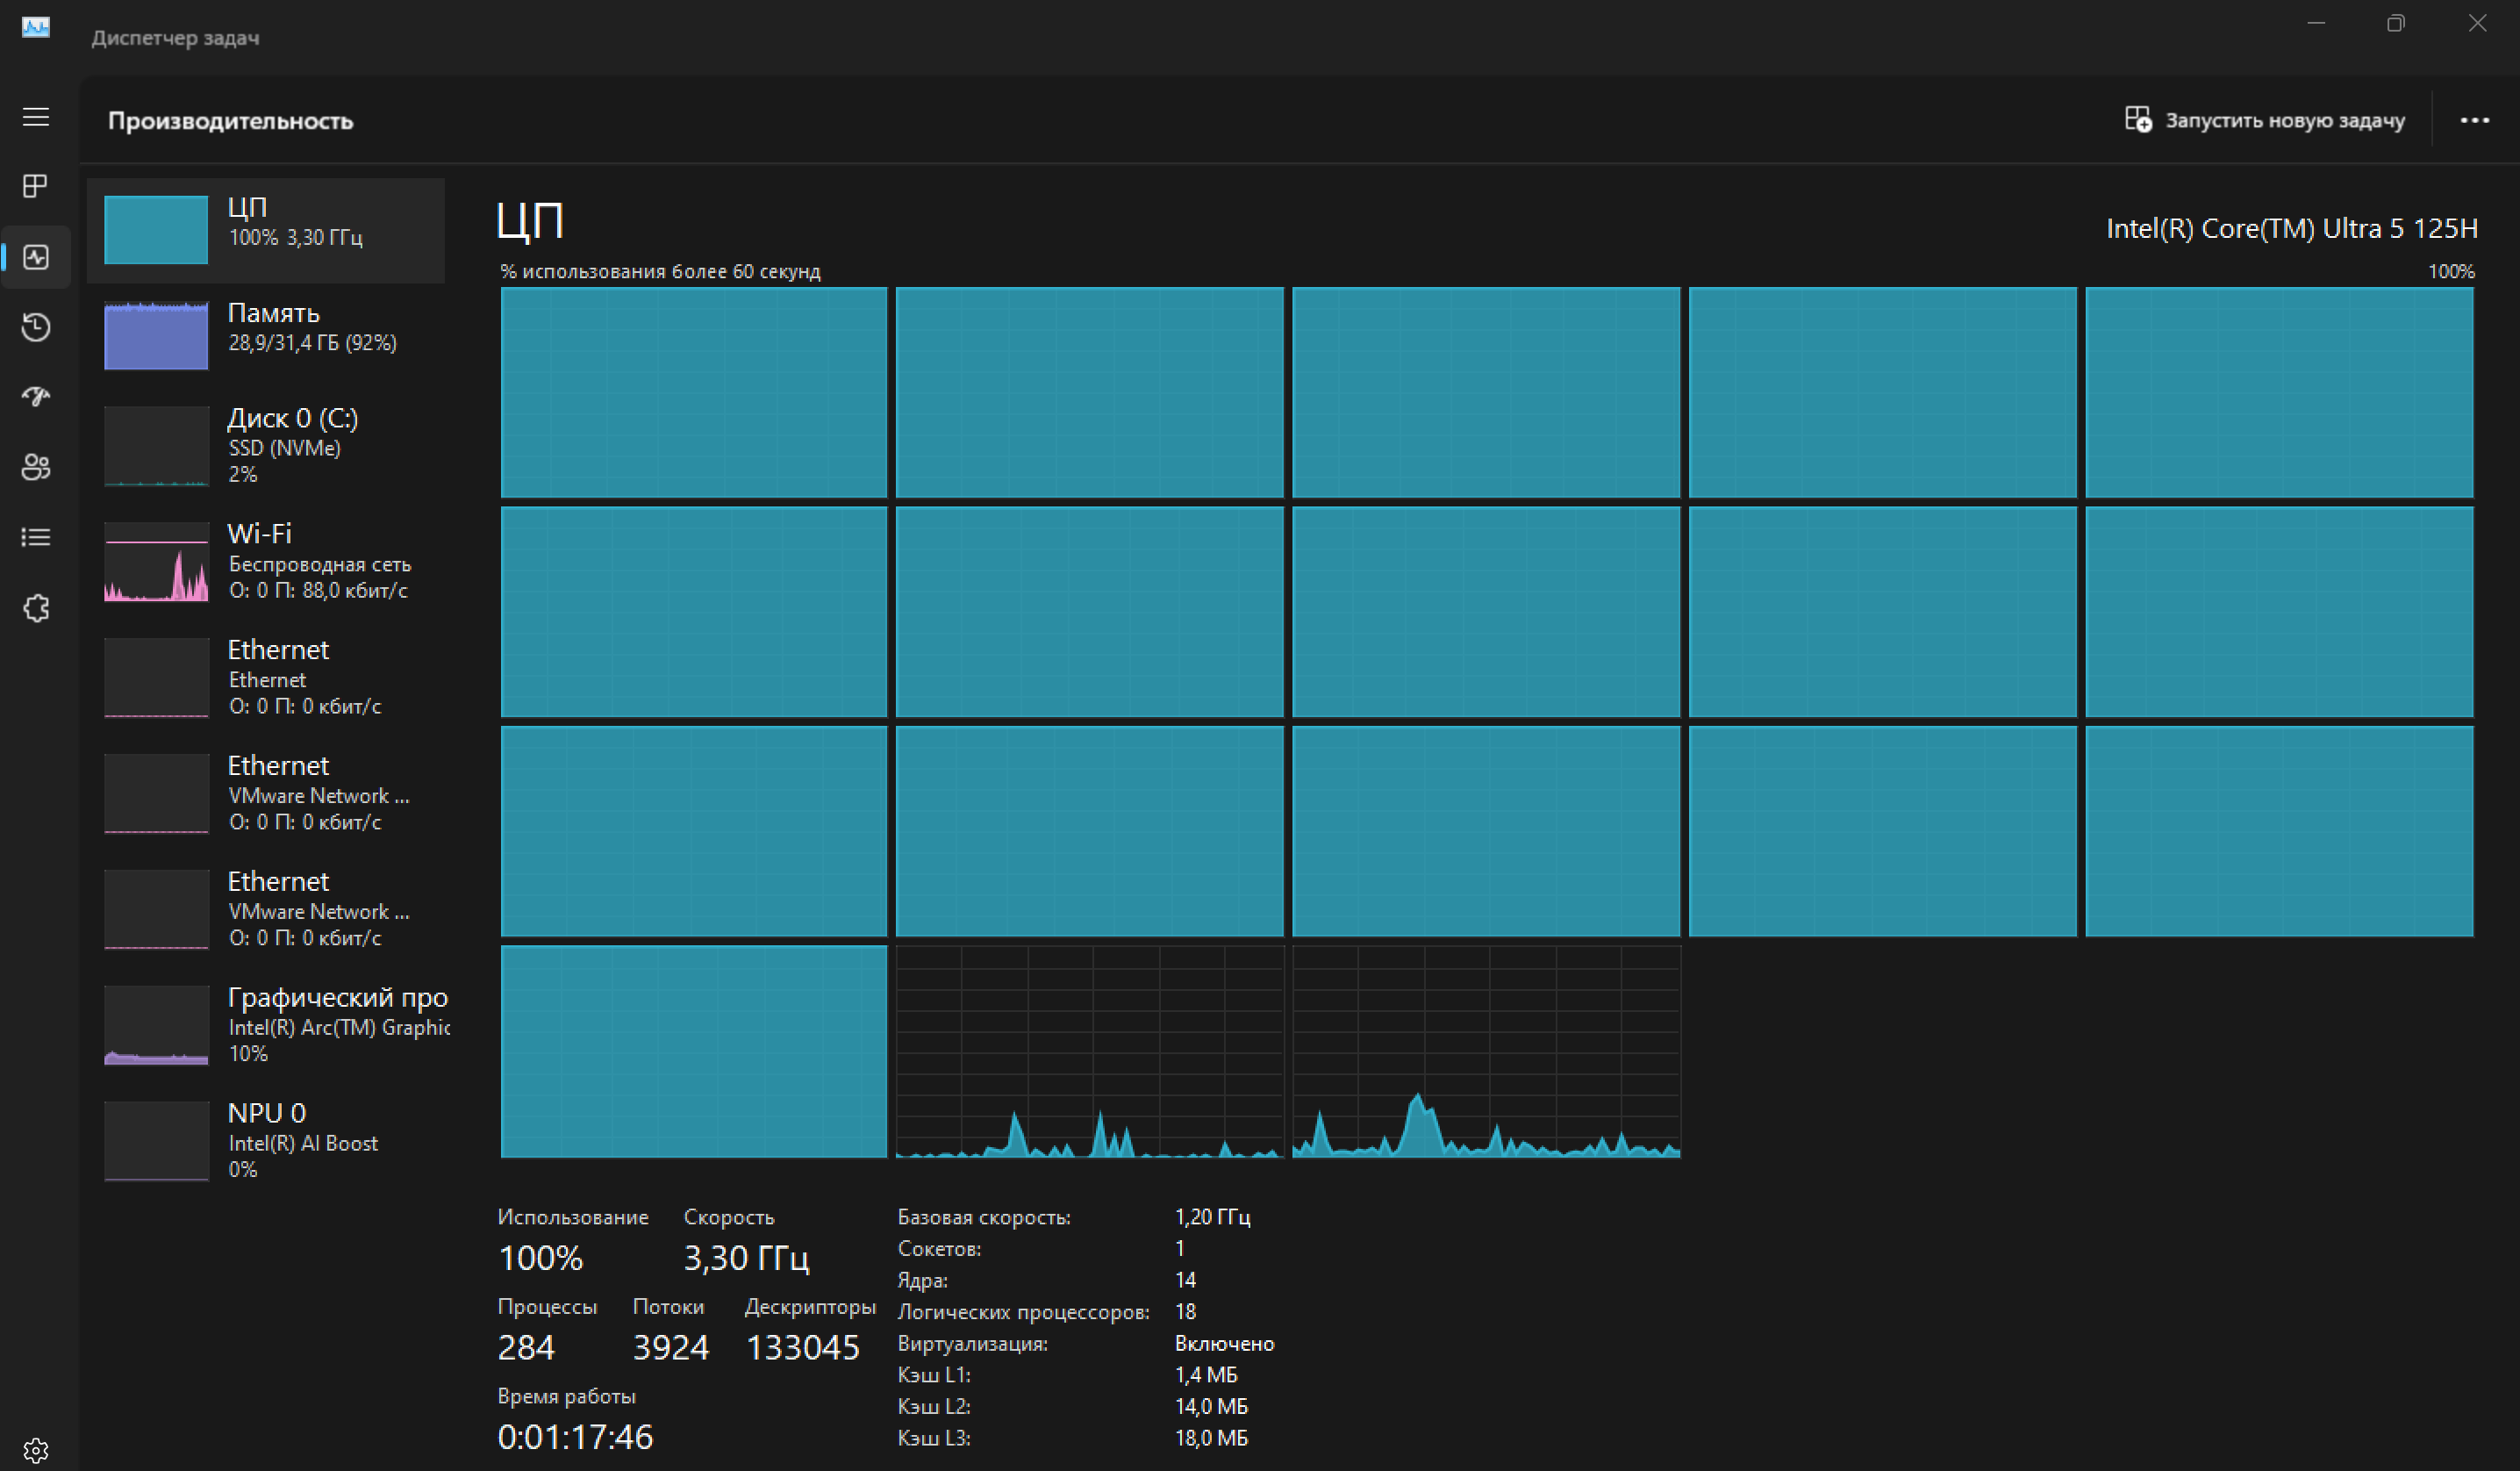
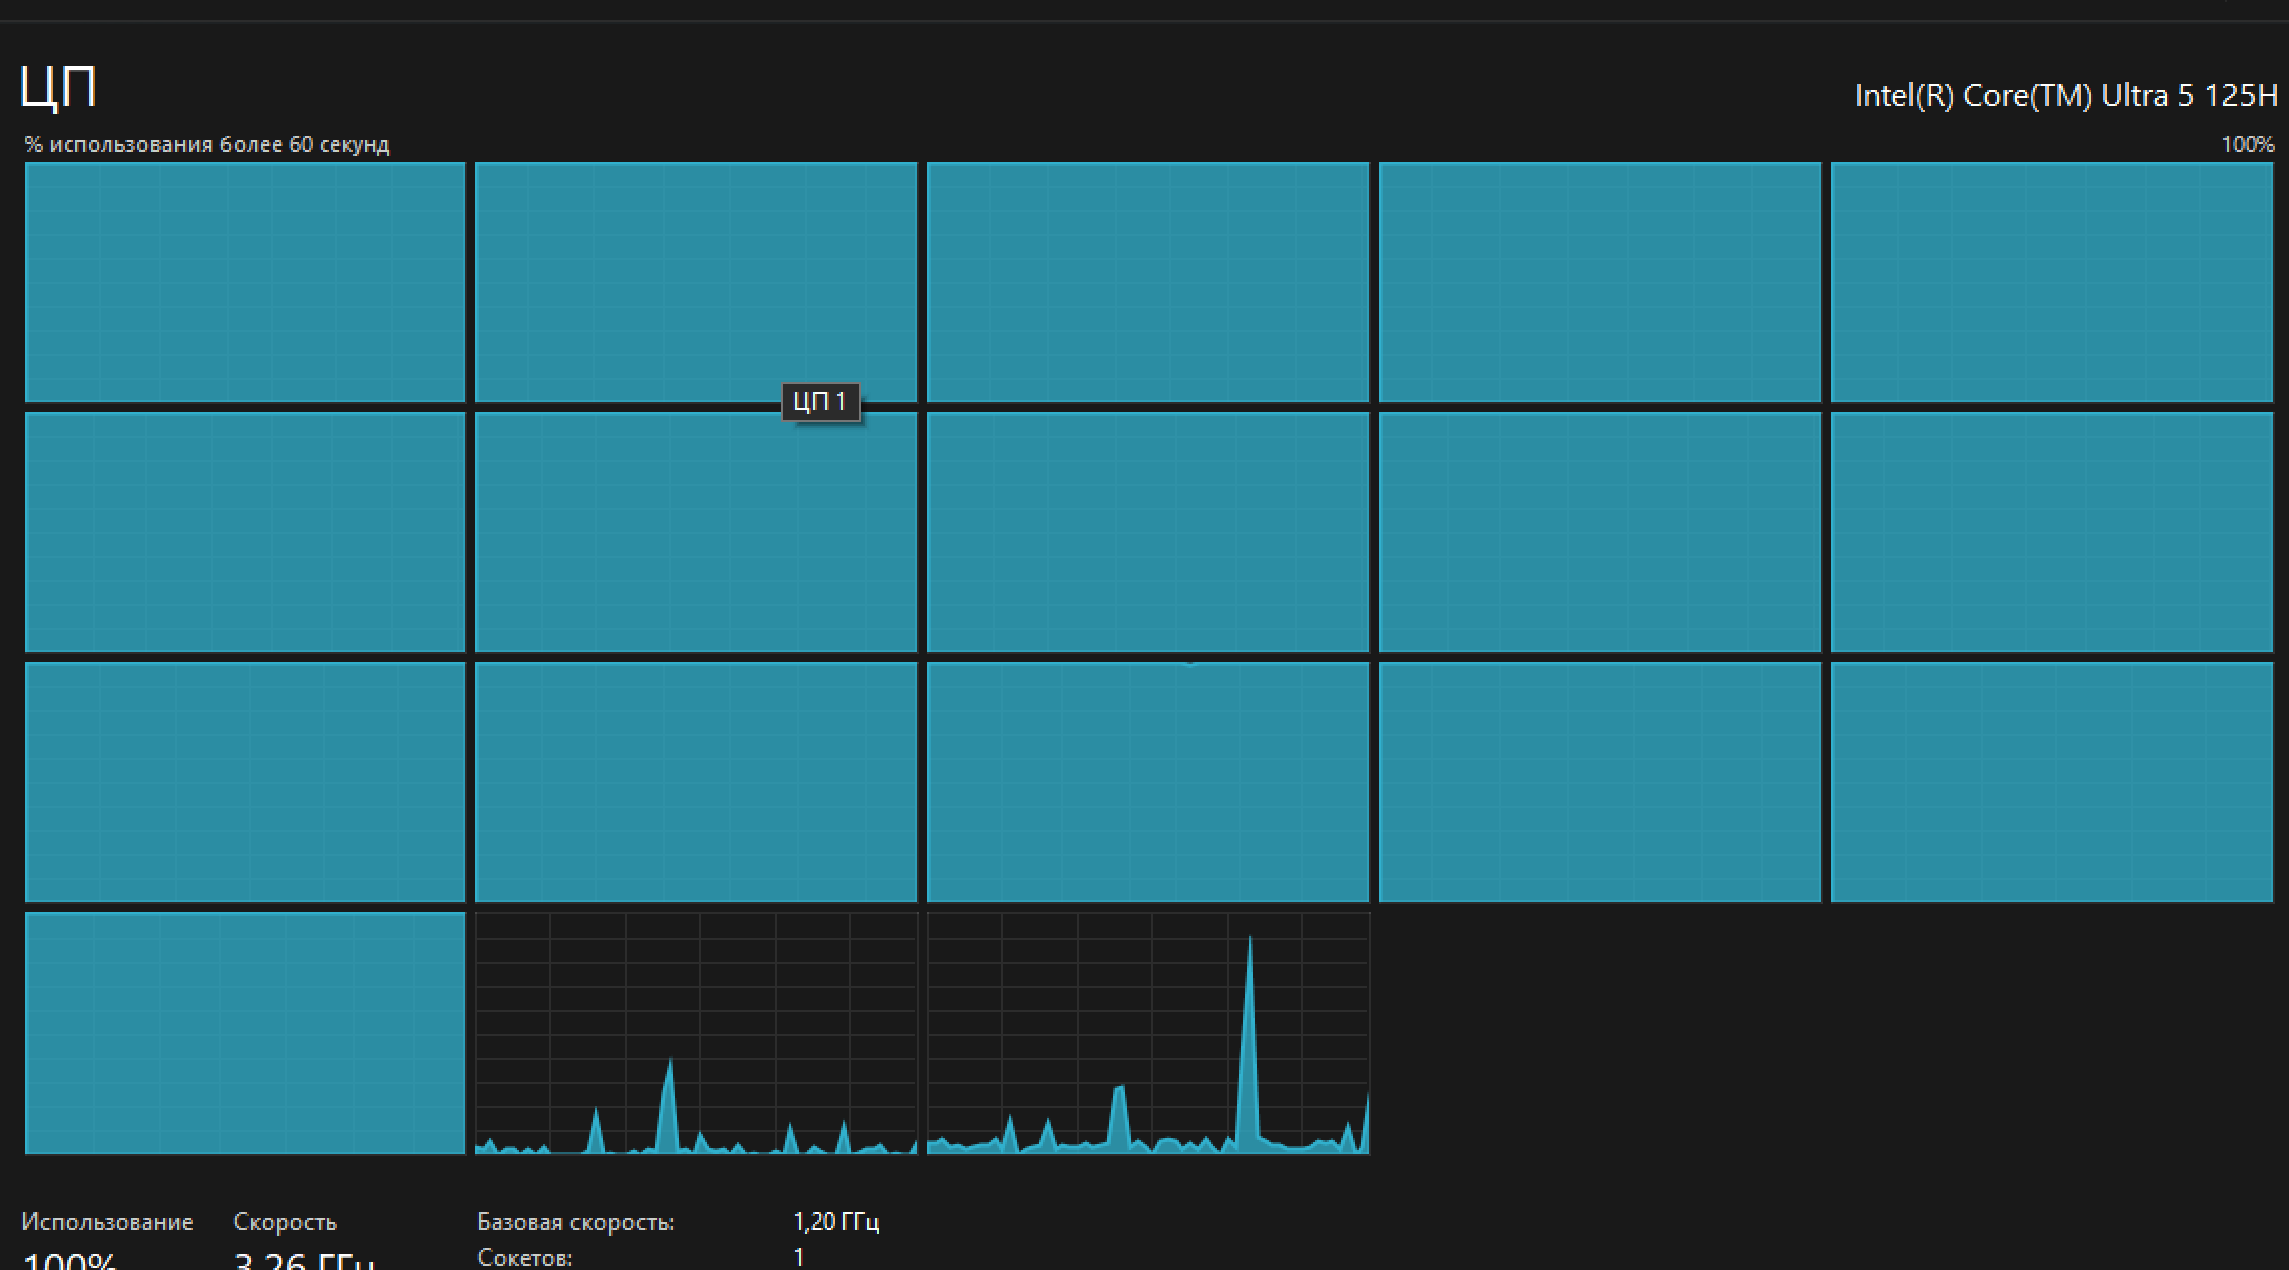